# MATH 6397 - Computational Challenge 2
## Quasi-stationary distributions in the birth-death model
    
    
**Group 2:** Thuyen (presenter), Danial, Manoj and Daniel.


## Computational Results

First, we import necessary libraries and defined some functions. The problem requires to plot *several* trajectories and find the *mean* time to extinction, so we create 2 functions, `popTrajectories` and `extinctionTime`, for those repetitive tasks. The implementations of the 2 functions contains 2 other repetitive tasks: compute the birth/dead probabilities and the change of population based on those probabilities. Therefore, we introduce two other functions: `findProp` and `changePop`.

Those subroutines are optimized by `jit` function from `Numba` library.

In [9]:
# Libraries

import numpy as np 
import time
from numba import jit

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
# sns.set(style="whitegrid")


# Function: Change of Population
@jit(nopython=True)
def changePop(b, d):
    """This function returns the change of population after 1 time step based on the birth/death probabilies.

    Attributes:
        b    birth probability
        d    death probability
    """
    s = np.random.random_sample()
    if   s < b:
        return 1
    elif s > (b+d):
        return 0
    else:
        return -1


# Function: Find Probability of Birth/Dearth/None
@jit(nopython=True)
def findProp(r, K, currentpop):
    """This function returns the birth/death probabilies based on the current population.

    Attributes:
        currentpop     current population
        r              growth rate
        K              carrying capacity
    """
    b = r*(currentpop - np.power(currentpop, 2)/(2*K))
    d = r*np.power(currentpop, 2)/(2*K)
    return b, d


# Function: Generate One Population Trajectory
@jit(nopython=True)
def popTrajectory(endtime, r, K, initpop):
    """This function returns an array containning the population from time 0 to 'endtime'-1.

    Attributes:
        endtime    maximum time of simulation + 1
        r          growth rate
        K          carrying capacity
        initpop    population at time 0
    """
    pop    = np.zeros(t)
    pop[0] = initpop
    for k in range(endtime-1):
        if pop[k] < 1:
            break
        else:
            b, d     = findProp(r, K, pop[k])
            pop[k+1] = pop[k] + changePop(b, d)
    return pop


# Function: Extinction time
#---> Question: does this function run in finite time? Almost surely!
@jit(nopython=True)
def extinctionTime(r,K,initpop):
    """This function returns the extinction time of a population by simulation.

    Attributes:
        r          growth rate
        K          carrying capacity
        initpop    population at time 0
    """
    extime = 0
    while initpop > 0:
        extime  += 1
        b, d     = findProp(r, K, initpop)
        initpop += changePop(b, d)
    return extime


# Function: Analytical Extinction Time
@jit(nopython=True)
def anaExtinctionTime(r,K,initpop):
    """This function returns the extinction time of a population by theoretical result.

    Attributes:
        r          growth rate
        K          carrying capacity
        initpop    population at time 0
    """
    N   = 2*K
    pop = np.arange(0,N+1)
    b   = r*(pop - np.power(pop,2)/N)
    d   = r*np.power(pop,2)/N
    ex  = 0
    for i in range(initpop):
        for j in range(i+2,N+1):
            ex = ex + 1/d[i+1] + np.prod(b[i+1:j])/np.prod(d[i+1:j+1])
    return ex

**Question 1.1.** Choose $r = 0.004, K = 50.$ Plot several trajectories to get a feel for the behavior of the population.

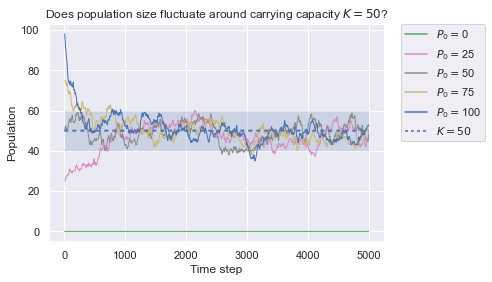

Computational time is 4.798330545425415 seconds.


In [3]:
# Generate and plot some population trajectories
# --- Intial Parameters
r = 0.004 
K = 50     # Maximum population size is 2K
t = 5000   # End time

aP0 = [0, 25, 50, 75, 100]  # Initial population

start = time.time()

#--- Plot
current_palette = sns.color_palette()
for P0 in aP0:
    pop      = popTrajectory(t, r, K, P0)
    tm       = np.linspace(0, t-1, t)
    time_pop = pd.DataFrame(pop, tm, ['$P_0=${p}'.format(p=P0)])
    time_pop = time_pop.rolling(7).mean()
    ax = sns.lineplot(data=time_pop, palette=[current_palette[np.random.randint(0,len(current_palette))]], linewidth=1)

capa      = K*np.ones(len(tm))
time_capa = pd.DataFrame(capa, tm, ['$K={k}$'.format(k=K)])
ax_capa   = sns.lineplot(data=time_capa, dashes=[(2,2)], linewidth=2)
ax.fill_between(x=tm, y1= 1.2*K*np.ones(len(tm)), y2=0.8*K*np.ones(len(tm)), alpha=0.2)

ax.set(xlabel='Time step', ylabel='Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title('Does population size fluctuate around carrying capacity $K = {P}$?'.format(P=K))
plt.show()

fig = ax.get_figure()
fig.savefig("1-1-PopulationTrajectories.png") 

end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

As we can see from the picture, the populations *seem* to fluctuate around the carrying capacity $K=50$, except when initial population is 0. The trajectories are smoothened by `rolling` function from `pandas` library to make it easier to see this behavior.

Lo and behold, this picture is misleading: it is proved that if we wait long enough, the populations will become extinct, almost surely!

**Question 1.2.** Create a histogram of the population size at $t=3000$.

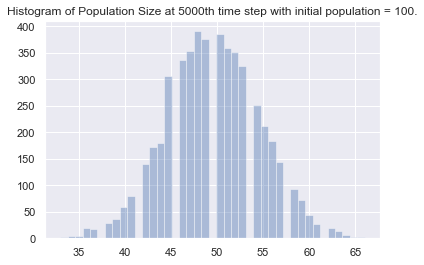

Computational time is 1.5656468868255615 seconds.


In [4]:
#--- Histogram of population time at t=3000
ntrial = 5000
initpop = 100

start = time.time()

s = []
for i in range(ntrial):
    pop = popTrajectory(t, r, K, initpop)
    s.append(pop[t-1])

pop_hist = sns.distplot(s, hist=True, kde=False)
plt.title('Histogram of Population Size at {T}th time step with initial population = {P}.'.format(T=t,P=P0))
# plt.legend(loc="upper left")
plt.show()

fig = pop_hist.get_figure()
fig.savefig("1-2-Histogram.png") 

end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

**Question 2.** Mean time to extinction.

Initial population = 1 ====> Time to extinction = 604427.6835201832.
Initial population = 2 ====> Time to extinction = 647122.8624215282.
Initial population = 3 ====> Time to extinction = 654111.062582038.
Initial population = 4 ====> Time to extinction = 656101.5019353175.
Initial population = 5 ====> Time to extinction = 656924.9817197438.
Initial population = 6 ====> Time to extinction = 657352.6240459988.
Initial population = 7 ====> Time to extinction = 657605.5813238373.
Initial population = 8 ====> Time to extinction = 657766.611587553.
Initial population = 9 ====> Time to extinction = 657873.3208636149.
Initial population = 10 ====> Time to extinction = 657945.3333190802.
Initial population = 11 ====> Time to extinction = 657993.9491195118.
Initial population = 12 ====> Time to extinction = 658026.1564057136.
Initial population = 13 ====> Time to extinction = 658046.5126495919.
Initial population = 14 ====> Time to extinction = 658058.1139345503.
Initial population = 15 ====> T

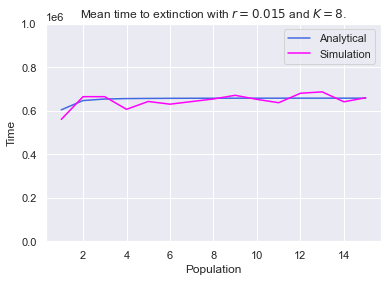

Computational time is 42.484859228134155 seconds.


In [23]:
# Plot the mean time to extinction
#--- Intial Parameters

r = 0.015
K = 8

start = time.time()

p0 = np.arange(1,2*K) # generate the initial population vector
lp0 = len(p0)

ntrial = 100 # number of simulation for each element of p0

#--- Analytical results
ana_mean_extime = np.zeros(lp0)
for i in range(lp0):
    ana_mean_extime[i] = anaExtinctionTime(r, K, p0[i])
    print('Initial population = {p} ====> Time to extinction = {t}.'.format(p=p0[i],t=ana_mean_extime[i]))

pop_ana_meanex  = pd.DataFrame(ana_mean_extime,p0,['Analytical'])
plot_ana_meanex = sns.lineplot(data=pop_ana_meanex, palette=['royalblue'])


#--- Simulation results
mean_extime = np.zeros(lp0)
for i in range(lp0):
    aextime = np.zeros(ntrial)
    for j in range(ntrial):
        aextime[j] = extinctionTime(r,K,p0[i])
    
    mean_extime[i] = np.mean(aextime)


pop_meanex  = pd.DataFrame(mean_extime,p0,['Simulation'])
plot_meanex = sns.lineplot(data=pop_meanex, palette=['magenta'])

plot_meanex.set(xlabel='Population', ylabel='Time')
plot_meanex.set(ylim=(0, 1000000))
plt.title('Mean time to extinction with $r={r0}$ and $K={K0}$.'.format(r0=r,K0=K))
plt.show()

fig = plot_meanex.get_figure()
fig.savefig("2-1-ExtinctionTime.png") 

end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

The above graph compares the mean time to extinction generated by simulation with the one obtained from theoretical results.

The above graph suggests that most tracjectories seem to become extinct after 700000 time steps. As a sanity check, we plot two trajectories up to that time (keep in mind that due to randomness, in a unlucky (or lucky?) run, the species is still extant!). 

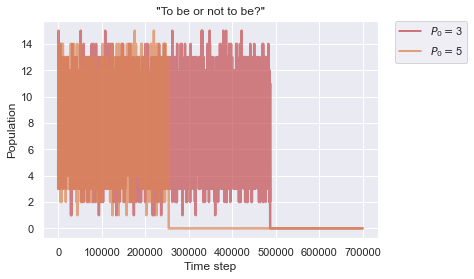

Computational time is 83.2960090637207 seconds.


In [25]:
# Generate and plot some population trajectories that may extinct
# --- Intial Parameters

r = 0.015
K = 8
t = 700000


aP0 = [3,5]

start = time.time()

#--- Plot
current_palette = sns.color_palette()
for P0 in aP0:
    pop = popTrajectory(t, r, K, P0)
    tm = np.linspace(0, t-1, t)
    time_pop = pd.DataFrame(pop, tm, ['$P_0=${p}'.format(p=P0)])
#     time_pop = time_pop.rolling(100).mean()
    ax = sns.lineplot(data=time_pop, palette=[current_palette[np.random.randint(0,len(current_palette))]], linewidth=2.5, alpha = 0.7)

ax.set(xlabel='Time step', ylabel='Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title(' "To be or not to be?" ')
plt.show()

fig = ax.get_figure()
fig.savefig("2-2-ExtinctionTrajectories.png") 

end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

How to quantify our "luck" of finding a species that are still in existence at $t=700000$? The following histogram sheds some light on the probability that a trajectory dies out or not.

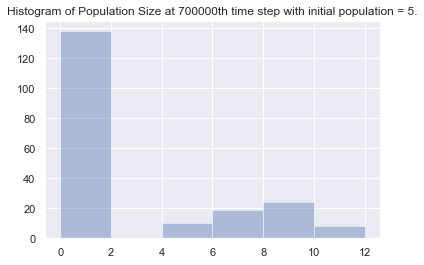

Computational time is 4.07082462310791 seconds.


In [26]:
#--- Histogram of population size at large end time t
ntrial = 200
initpop = 5

start = time.time()

s = []
for i in range(ntrial):
    pop = popTrajectory(t, r, K, initpop)
    s.append(pop[t-1])

pop_hist = sns.distplot(s, hist=True, kde=False)
plt.title('Histogram of Population Size at {T}th time step with initial population = {P}.'.format(T=t,P=P0))
plt.show()

fig = pop_hist.get_figure()
fig.savefig("2-3-Histogram.png") 

end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

So, with 200 trajectories starting from 5, there is quite a chance that we can randomly choose one that doesn't reach 0 at $t = 700000$.

**Question 3.** *To be, or not to be, that is the question...*

We now discuss how the answers to the previous two questions can be consistent: The first suggests
that the population reaches a stable distribution around the carrying capacity. The second
suggests that the population goes extinct.

As we mentioned before, the fluctuation around the carrying capacity is just a illusion! The doomsday will come eventually (almost surely). To prove this, we need the following theoretical results.

## Theoretical Results

*This is a joint work of Group 1 (Triet Duong) and Group 2 (Thuyen Dang).*


Given a birth-death process with transition probability:
$$\begin{align}
\label{1}
P(X_{t+1} = j+1 | X_{t} = j) 
&= b_{j}\\
P(X_{t+1} = j-1 | X_{t} = j) 
&= d_{j}\\
P(X_{t+1} = j | X_{t} = j) 
&= 1 - (b_{j}+d_{j}).
\end{align}$$

Suppose the capacity $N = 2K$ for some integer $K > 0$. Moreover, we
assume the state 0 is absorbing (i.e., extinction) and state $N$ is
reflecting (i.e., when never the population reaches $2N$, the birth
probability $b_N = 0$).

Let $\mathbf{s}^0$ be the hitting time (or first passage time) defined
by 
$$\begin{align}
\label{eq:1}
  \mathbf{s}^{W} = \inf \{ t \ge 0 \colon X_{t} \in W \},
\end{align}$$
where $W$ is a subset of state space $\left\{ 0, \ldots, N
\right\}$. If the population at time $t = 0$ is $k$, then the
expectation of mean time to extinction is denoted by
$E_k[\mathbf{s}^0]$, which admits the explicit formula:
$$\begin{align}
\label{eq:2}
E_k [\mathbf{s}^0] = \sum_{i=0}^{k-1} \left( \frac{1}{d_{i+1}} +
  \sum_{j = i+2}^N \frac{b_{i+1} \cdots b_{j-1}}{d_{i+1}\cdots d_{j}}\right).
\end{align}$$

The formula can be proved rigorously by generating function, see
Chapter 5 of the book Wolfgang Woess, Denumerable Markov Chain.


*Remark.* The birth-death process has a continuous deterministic counterpart,
which is the logistic equation 
$$\begin{align}
\label{eq:3}
\frac{dn}{dt} = rn \left( 1 - \frac{n}{K} \right).
\end{align}$$
(Notice the similarity between the right hand side with $b_i - d_i =
ri (1 - i/K)$.) In the deterministic model, the population never
extincts if it's near the capacity $2K$. However, if one adds
randomness into this model, the theoretical result above says that
the population will become extinct eventually. 

The following script compute the mathematical expectation of the time to extinction for any given growth rate $r$, carrying capacity $K$ and initial population.

In [21]:
# Expected time to extinction
r = 0.004     # growth rate
K = 50        # carrying capacity
initpop = 100 # initial population

ex = anaExtinctionTime(r,K,initpop)
print('The expectation of extinction time is {t} time steps.'.format(t = ex))

The expectation of extinction time is 6.469670296402451e+30 time steps.


Now we want to see how the mean time to extinction (both theoretical and experimental) varies when $r$ and $K$ vary.

First, let $r$ be fixed:

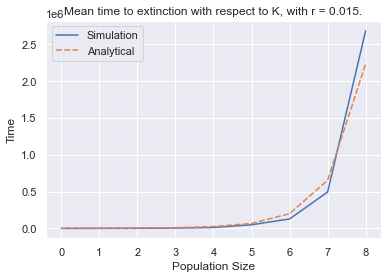

Computational time is 8.34284496307373 seconds.


In [33]:
# Plot the mean time the population reaches extinction with fixed r
r = 0.015
K = 9

ntrial = 50

X0 = []
final_pop = []
mean_time = []
mean_time_ex = []

start = time.time()

for j in range(K):
    ntime = []
    ntime_ex = []
    X0.append(j+1)
    for k in range(ntrial):
        x0 = np.random.randint(1, 2*j+2)
        i = extinctionTime(r, j+1, x0)
        ex = anaExtinctionTime(r, j+1, x0)
        ntime.append(max(i,0))
        ntime_ex.append(max(ex,0))
    mean_time.append(sum(ntime)/ntrial)
    mean_time_ex.append(sum(ntime_ex)/ntrial)


pop_meanex = pd.DataFrame({
#     'Population Size K': X0,
    'Simulation': mean_time,
    'Analytical': mean_time_ex})

plot_meanex = sns.lineplot(data=pop_meanex)
plot_meanex.set(xlabel='Population Size', ylabel='Time')
plt.title('Mean time to extinction with respect to K, with r = {r0}.'.format(r0=r))
plt.show()

fig = plot_meanex.get_figure()
fig.savefig("3-1-ExtinctionTimeFixed_r.png") 


end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))

Now, let $K$ be fixed:

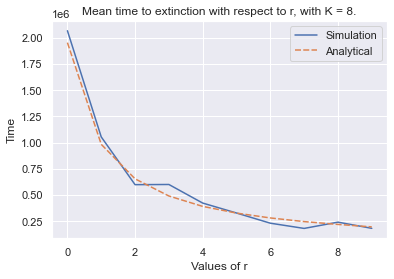

Computational time is 12.881515741348267 seconds.


In [32]:
# Plot the mean time the population reaches extinction with fixed K = 8
r = np.linspace(0.005,0.05,10)
K = 8

ntrials = 50

X0 = []
final_pop = []
mean_time = []
mean_time_ex = []

start = time.time()

for j in range(len(r)):
    ntime = []
    ntime_ex = []
    X0.append(r[j])
    for k in range(ntrials):
        x0 = np.random.randint(1, 2*K+1)
        i  = extinctionTime(r[j], K, x0)
        ex = anaExtinctionTime(r[j], K, x0)
        ntime.append(max(i,0))
        ntime_ex.append(max(ex,0))
    mean_time.append(sum(ntime)/ntrials)
    mean_time_ex.append(sum(ntime_ex)/ntrials)
    

pop_meanex = pd.DataFrame({
#     'Population Size K': X0,
    'Simulation': mean_time,
    'Analytical': mean_time_ex})

plot_meanex = sns.lineplot(data=pop_meanex)
plot_meanex.set(xlabel='Values of r', ylabel='Time')
plt.title('Mean time to extinction with respect to r, with K = {K0}.'.format(K0=K))
plt.show()

fig = plot_meanex.get_figure()
fig.savefig("3-2-ExtinctionTimeFixed_r.png") 


end = time.time()

print('Computational time is {t} seconds.'.format(t=end-start))